In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [ ]:
import os
path_dir: str = r"/path/to/your/data"

In [3]:
#Get some data
inputList,timeList=ppt.getScopeWaveforms(os.sep.join([path_dir, 'width100ns_0_100mV_ampScan.ch4.traces']),False)
outputList,timeList=ppt.getScopeWaveforms(os.sep.join([path_dir, 'width100ns_0_100mV_ampScan.ch3.traces']),False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch3.traces",False)

(1000, 5002) (1000, 5002) (5002,)


Text(0, 0.5, 'Voltage (Volts)')

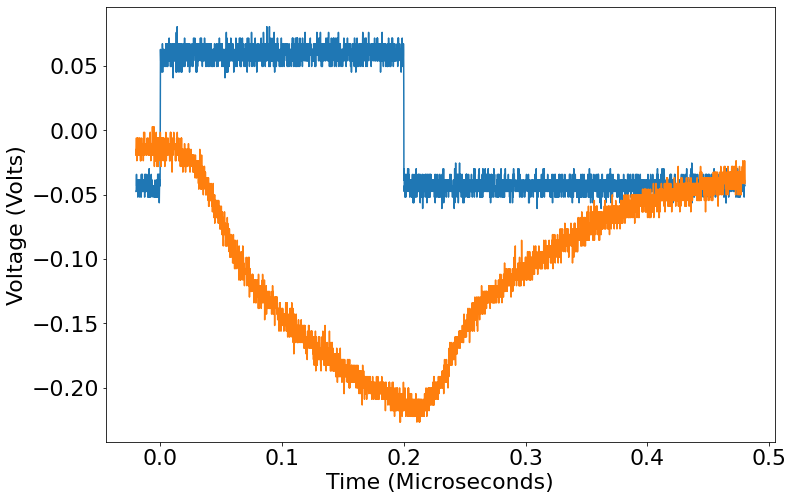

In [4]:
print(outputList.shape,inputList.shape,timeList.shape)

#Plot the first waveforms
fig, ax = plt.subplots()
ax.plot(timeList,inputList[0],label="Input Pulse")
ax.plot(timeList,outputList[0],label="Preamp Output")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")

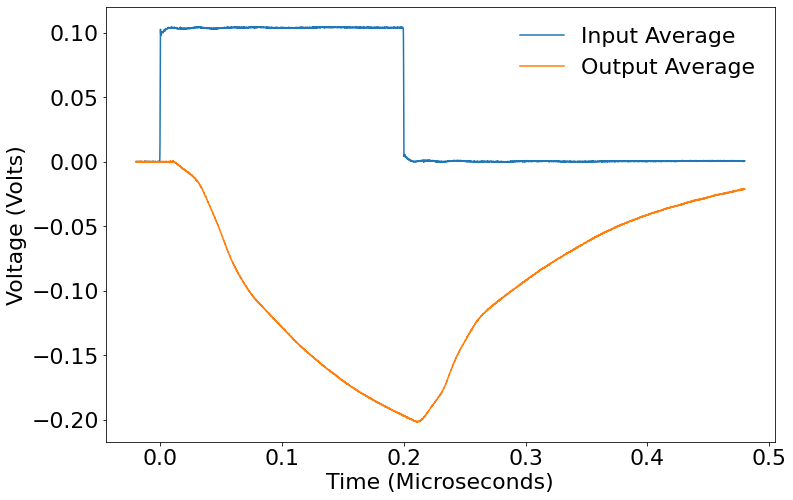

In [5]:
dt=timeList[1]-timeList[0]
fs=1./dt
inputAvg=np.mean(inputList,axis=0)
outputAvg=np.mean(outputList,axis=0)
inputAvg-=np.mean(inputAvg[0:100])
outputAvg-=np.mean(outputAvg[0:100])
#print(inputAvg.shape)

inputSmooth=ppt.butter_lowpass_filter(inputList[0],1000,fs,2)
outputSmooth=ppt.butter_lowpass_filter(outputList[0],1000,fs,2)

fig, ax = plt.subplots()
#ax.plot(timeList,inputSmooth,label="Input Smooth")
#ax.plot(timeList,outputSmooth,label="Output Smooth")
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()

In [120]:
#with this part I want to find the steps in both input and output
#my code works this way: starting from the elenventh point, if the new point is higher/lower than twice the RMS of the previous
#ten points, then we have a step. Since we are interested only in the first step, this should work.

def step_finder_input(x):
    for i in range(len(x)):
        if x[i]>0.05:
            print('found!')
            print(x[i])
            return i
        
def step_finder_output(x):
    for i in range(20, len(x)-20):
        mini_x_2 = []
        for j in range(20):
            mini_x_2.append(x[i-j]*x[i-j])
        if x[i]<2*np.sqrt(np.mean(mini_x_2)):
            print(np.sqrt(np.mean(mini_x_2)))
        if x[i]>2*np.sqrt(np.mean(mini_x_2)):
            print('found!')
            print(np.sqrt(np.mean(mini_x_2)))
            print(x[i])
            return i

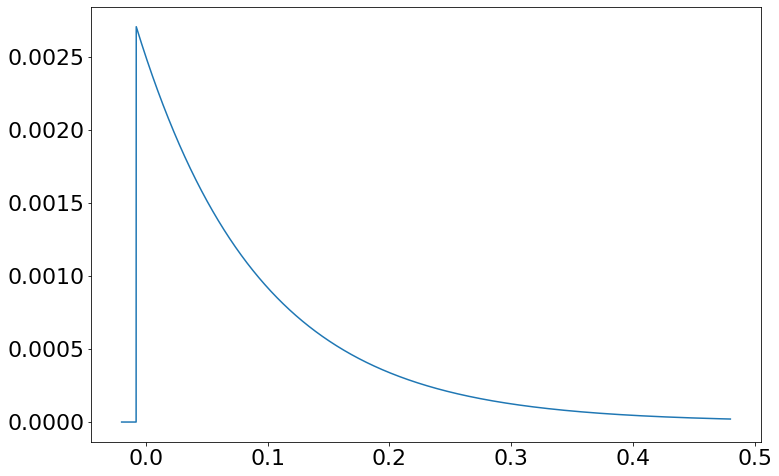

In [11]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls wth a given time constant
def response_ryan(x,offset,tau,norm):
    conds = [x<0,(x>=0) & (x < offset), x>=offset]   #The two regions of x
    funcs = [lambda x: 0, lambda x:0, lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


offset=timeList[120]
tau=0.1
norm=0.0025
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response_ryan(timeList[0:10000],offset,tau,norm),label="Response Function")

[-0.00802944  0.11682089 -0.00186949]


C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


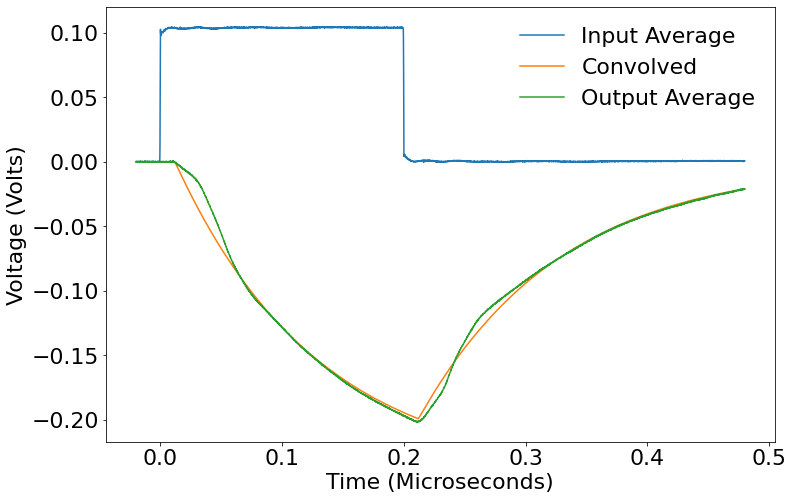

In [12]:
def func(xdata,offset,tau,norm):
    return scipy.signal.convolve(xdata, response_ryan(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 


from scipy.optimize import curve_fit
popt_ryan, pcov_ryan = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
print(popt_ryan)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func(inputAvg,popt_ryan[0],popt_ryan[1],popt_ryan[2]),label="Convolved")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()
#ax.set_xlim(-0.01,0.111)

In [ ]:
#my experimental stuff

In [111]:
step_finder_output(outputAvg)

0.00016248753459414722
0.0001611678087334417
0.0001688047622428335
0.00017265344251060123
0.00017149533404548365
0.00017634260417227583
0.00017908892842672714
0.00017404258427144314
0.0001682657568019413
0.000168407831689449
0.0001669690685741629
0.00017021751199225904
0.00016929521832902494
0.00016775296489560988
0.00016199889338046008
0.0001702948898317546
0.00015422894514885915
0.00016673196271933843
0.00016565344729920493
0.00016985292125811974
0.00017052011215333026
0.00017672392393603718
0.00016799781454131862
0.0001618984305937188
0.0001589748395008329
0.00015410390054907357
0.00015409984471998376
0.00015583417793291895
0.0001620493424755045
found!
0.00018416753519932437
0.00040663412543479396


49

In [106]:
inputAvg[70]

0.0003401655106479301

In [13]:
from sklearn.metrics import r2_score
r2_score(outputAvg, func(inputAvg,popt_ryan[0],popt_ryan[1],popt_ryan[2]))

0.992961607861957

In [37]:
offset=timeList[200]
newtimeList=timeList-offset

0.21060000281181154
-0.008000000106811456


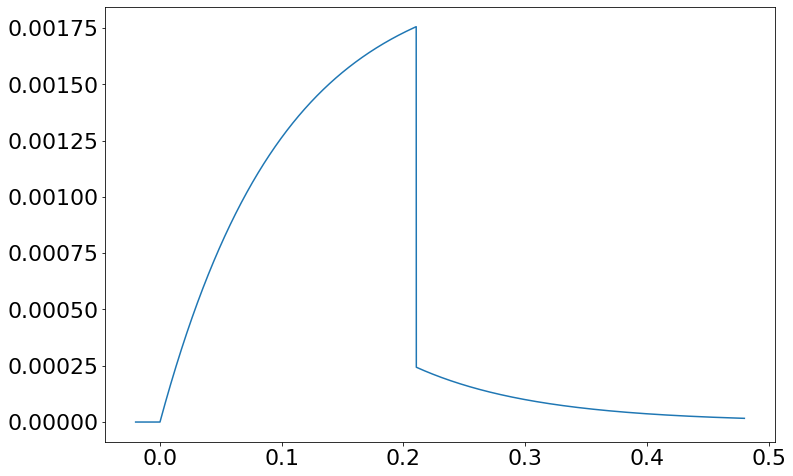

In [38]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x < offset, (x>=offset) & (x<peak),x>=peak]   #The two regions of x
    funcs = [lambda x:0, lambda x: norm*(1-np.exp(-x/tau)), lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it

peak=newtimeList[np.argmin(outputAvg)]
print(peak)
#offset=timeList[120]
#offset = 0
print(newtimeList[120])
tau=0.1
norm=0.0020
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response(newtimeList[0:10000],offset,tau,norm),label="Response Function")

[-2.88700200e-05  2.28902618e-06 -9.55410753e-04]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24432\3993205398.py:5: RuntimeWarning: overflow encountered in exp
  funcs = [lambda x:0, lambda x: norm*(1-np.exp(-x/tau)), lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\signal\signaltools.py:507: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)
C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


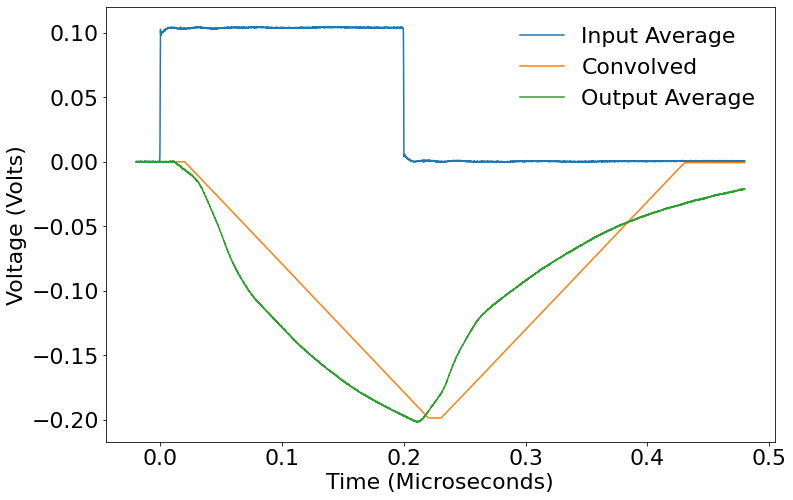

In [39]:
def func(xdata,offset,tau,norm):
    return scipy.signal.convolve(xdata, response(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 


from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
print(popt)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func(inputAvg,popt[0],popt[1],popt[2]),label="Convolved")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()
#ax.set_xlim(-0.01,0.111)

In [40]:
from sklearn.metrics import r2_score
r2_score(outputAvg, func(inputAvg,popt[0],popt[1],popt[2]))

0.7559713588687876